# MOSDBDiscrete
In this module, we will have a brief overview of the `MOSDBDiscrete` class, which manages a transistor characterization database and provide methods for designers to query transistor small signal parameters.

## MOSDBDiscrete example
To use the transistor characterization database, evaluate the following cell, which defines two methods, `query()` and `plot_data()`.

In [5]:
import os
import pprint

import numpy as np
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import ticker

from verification_ec.mos.query import MOSDBDiscrete

interp_method = 'spline'
spec_file = os.path.join(os.environ['BAG_WORK_DIR'], 'demo_data', 'mos_char_nch', 'specs.yaml')
env_default = 'tt'
intent = 'standard'


def query(vgs=None, vds=None, vbs=0.0, vstar=None, env_list=None):
    """Get interpolation function and plot/query."""

    spec_list = [spec_file]
    if env_list is None:
        env_list = [env_default]

    # initialize transistor database from simulation data
    nch_db = MOSDBDiscrete(spec_list, interp_method=interp_method)
    # set process corners
    nch_db.env_list = env_list
    # set layout parameters
    nch_db.set_dsn_params(intent=intent)
    # returns a dictionary of smal-signal parameters
    return nch_db.query(vbs=vbs, vds=vds, vgs=vgs, vstar=vstar)


def plot_data(name='ibias', bounds=None, unit_val=None, unit_label=None):
    """Get interpolation function and plot/query."""
    env_list = [env_default]
    vbs = 0.0
    nvds = 41
    nvgs = 81
    spec_list = [spec_file]

    print('create transistor database')
    nch_db = MOSDBDiscrete(spec_list, interp_method=interp_method)
    nch_db.env_list = env_list
    nch_db.set_dsn_params(intent=intent)

    f = nch_db.get_function(name)
    vds_min, vds_max = f.get_input_range(1)
    vgs_min, vgs_max = f.get_input_range(2)
    if bounds is not None:
        if 'vgs' in bounds:
            v0, v1 = bounds['vgs']
            if v0 is not None:
                vgs_min = max(vgs_min, v0)
            if v1 is not None:
                vgs_max = min(vgs_max, v1)
        if 'vds' in bounds:
            v0, v1 = bounds['vds']
            if v0 is not None:
                vds_min = max(vds_min, v0)
            if v1 is not None:
                vds_max = min(vds_max, v1)

    # query values.
    vds_test = (vds_min + vds_max) / 2
    vgs_test = (vgs_min + vgs_max) / 2
    pprint.pprint(nch_db.query(vbs=vbs, vds=vds_test, vgs=vgs_test))

    vbs_vec = [vbs]
    vds_vec = np.linspace(vds_min, vds_max, nvds, endpoint=True)
    vgs_vec = np.linspace(vgs_min, vgs_max, nvgs, endpoint=True)
    vbs_mat, vds_mat, vgs_mat = np.meshgrid(vbs_vec, vds_vec, vgs_vec, indexing='ij', copy=False)
    arg = np.stack((vbs_mat, vds_mat, vgs_mat), axis=-1)
    ans = f(arg)

    vds_mat = vds_mat.reshape((nvds, nvgs))
    vgs_mat = vgs_mat.reshape((nvds, nvgs))
    ans = ans.reshape((nvds, nvgs, len(env_list)))

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    if unit_label is not None:
        zlabel = '%s (%s)' % (name, unit_label)
    else:
        zlabel = name
    for idx, env in enumerate(env_list):
        fig = plt.figure(idx + 1)
        ax = fig.add_subplot(111, projection='3d')
        cur_val = ans[..., idx]
        if unit_val is not None:
            cur_val = cur_val / unit_val
        ax.plot_surface(vds_mat, vgs_mat, cur_val, rstride=1, cstride=1, linewidth=0, cmap=cm.cubehelix)
        ax.set_title('%s (corner=%s)' % (name, env))
        ax.set_xlabel('Vds (V)')
        ax.set_ylabel('Vgs (V)')
        ax.set_zlabel(zlabel)
        ax.w_zaxis.set_major_formatter(formatter)

    plt.show()


## Querying Small-Signal Parameters
To lookup transistor small signal parameters given a bias point, use the `query()` method by evaluating the following cell.  Feel free to play around with the numbers.

In [7]:
query(vgs=0.4, vds=0.5, vbs=0.0)

{'cdb': 6.248976739750918e-17,
 'cdd': 2.0328230225209529e-16,
 'cds': -2.4163000626635435e-17,
 'cgb': 9.9667025975909315e-19,
 'cgd': 1.6495553548122156e-16,
 'cgg': 3.6228642234598523e-16,
 'cgs': 1.9633421660500457e-16,
 'csb': 1.1021134465725367e-16,
 'css': 2.823825606356228e-16,
 'gb': 1.983603067386339e-05,
 'gds': 4.7199447230255847e-06,
 'gm': 9.4921401661788324e-05,
 'ibias': 1.229911354077092e-05,
 'vbs': 0.0,
 'vds': 0.5,
 'vgs': 0.4,
 'vstar': 0.2591431084128642}

## Plotting Small-Signal Parameters
`MOSDBDiscrete` stores each small signal parameter as a continuous function interpolated from simulation data.  This makes it easy to manipulate those functions directly (such as using an optimization solver).  For a simple example, the `plot_data()` method simply plots the functions versus $V_{gs}$ and $V_{ds}$.  Evaluate the following cell to see plots of various different small signal parameters.

create transistor database
{'cdb': 6.4025955718721141e-17,
 'cdd': 2.0379145885397669e-16,
 'cds': -3.5466715265482232e-17,
 'cgb': 1.5429673845401084e-18,
 'cgd': 1.7523221840073776e-16,
 'cgg': 3.8270843249717799e-16,
 'cgs': 2.0593324671190008e-16,
 'csb': 1.0744529426477156e-16,
 'css': 2.7791182571118944e-16,
 'gb': 3.6481190000000005e-05,
 'gds': 7.5989599999999985e-06,
 'gm': 0.00016568942499999993,
 'ibias': 3.9317119999999984e-05,
 'vbs': 0.0,
 'vds': 0.50249999999999995,
 'vgs': 0.60400000000000009,
 'vstar': 0.47458816397003006}


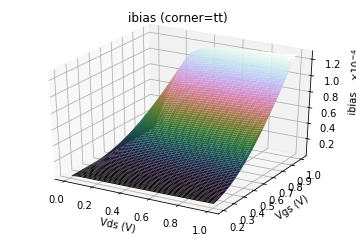

In [12]:
plot_data(name='ibias')